# Regresión Lineal

Realice un análisis exploratorio, tratamiento de datos, y entrene una Regresión Lineal para la variable de estatura (2.5 puntos), y una Regresión Logística para alguna variable categórica (de preferencia binaria) que proponga (2.5 puntos). Brinde interpretaciones de ambas a través de las betas o scores (2.5 puntos por cada una). Adicional realizar un Score Card del modelo de clasificación (+ 1 punto).

## 0. Preparación de ambiente

In [67]:
# Data Wrangling
import numpy as np
import pandas as pd

# Data View
from typing import Optional
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Data Viz
import plotly.express as px
#import cufflinks as cf

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split

# Model performance
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)



In [68]:
def estandarizar_df(df):
   
    df_estandarizado = df.copy()
    
    # 1. Limpiar nombres de columnas
    def limpiar_nombre(nombre, indice):
        nombre = str(nombre).strip()
        nombre = ' '.join(nombre.split())
        nombre = nombre.upper().replace(' ', '_')
        
        # Filtrar solo caracteres válidos
        nombre_limpio = ''.join(char for char in nombre if char.isalnum() or char == '_')
        
        if not nombre_limpio:
            nombre_limpio = f'COLUMNA_{indice+1}'
        
        return nombre_limpio
    
    # Crear nuevos nombres evitando duplicados
    nombres_nuevos = []
    nombres_vistos = set()
    
    for i, col in enumerate(df_estandarizado.columns):
        nombre_base = limpiar_nombre(col, i)
        nombre_final = nombre_base
        contador = 1
        
        while nombre_final in nombres_vistos:
            nombre_final = f"{nombre_base}_{contador}"
            contador += 1
        
        nombres_nuevos.append(nombre_final)
        nombres_vistos.add(nombre_final)
    
    df_estandarizado.columns = nombres_nuevos
    
    # 2. Procesar datos de cada columna
    for columna in df_estandarizado.columns:
        # Para columnas de tipo objeto (strings o mixtas)
        if df_estandarizado[columna].dtype == 'object':
            try:
                # Intentar convertir a numérico
                serie_numerica = pd.to_numeric(df_estandarizado[columna], errors='coerce')
                
                # Si se pudo convertir algún valor (no todos son NaN)
                if serie_numerica.notna().any():
                    # Mantener el tipo numérico para los convertibles
                    df_estandarizado[columna] = serie_numerica
                else:
                    # Si no hay valores numéricos, convertir strings a mayúsculas
                    df_estandarizado[columna] = df_estandarizado[columna].apply(
                        lambda x: x.upper() if isinstance(x, str) else x
                    )
            except:
                # Si hay error, solo convertir strings a mayúsculas
                df_estandarizado[columna] = df_estandarizado[columna].apply(
                    lambda x: x.upper() if isinstance(x, str) else x
                )
    
    return df_estandarizado



def completitud_datos(df: pd.DataFrame) -> pd.Series:    
    """
    Calcula el porcentaje de completitud de datos para DataFrames de Pandas.
    
    Esta función analiza cada columna del DataFrame y calcula el porcentaje de 
    valores nulos presentes, ordenados de mayor a menor porcentaje de nulos.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas a analizar.
        
    Returns
    -------
    pd.Series
        Serie de pandas con los nombres de las columnas como índice
        y los porcentajes de valores nulos (entre 0.0 y 1.0) como valores,
        ordenados de mayor a menor porcentaje de nulos.
        
    """
    return round(df.isnull().sum().sort_values(ascending=False) / df.shape[0], 4)

def impute_missing_values(df: pd.DataFrame, method: str = 'auto') -> pd.DataFrame:
    """
    Imputa valores faltantes usando diferentes métodos según el tipo de variable.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas con valores faltantes a imputar.
    method : str, default 'auto'
        Método de imputación a utilizar. Opciones:
        - 'auto': media para numéricas, moda para categóricas
        - 'mean': media para variables numéricas
        - 'median': mediana para variables numéricas
        - 'knn': K-Nearest Neighbors para numéricas, moda para categóricas
        
    Returns
    -------
    pd.DataFrame
        DataFrame con valores faltantes imputados.
        
    Raises
    ------
    ValueError
        Si el método especificado no es reconocido.
        
    Notes
    -----
    La función imprime información sobre el proceso de imputación para cada columna,
    incluyendo el método utilizado y los valores de relleno aplicados.
    """
    df_result = df.copy()
    print(f"Valores faltantes antes de imputar:\n{df_result.isnull().sum().sum()} en total")
    
    # Separar columnas numéricas y categóricas
    numeric_cols = df_result.select_dtypes(include=[np.number]).columns
    categorical_cols = df_result.select_dtypes(include=['object', 'category']).columns
    
    if method == 'knn':
        # Imputar categóricas con moda
        for col in categorical_cols:
            if df_result[col].isnull().sum() > 0:
                mode_value = df_result[col].mode()
                if not mode_value.empty:
                    fill_value = mode_value.iloc[0]
                else:
                    fill_value = 'Unknown'
                df_result[col].fillna(fill_value, inplace=True)
                print(f"Columna categórica '{col}': imputada con moda '{fill_value}'")
        
        # Imputar numéricas con KNN
        if len(numeric_cols) > 0 and df_result[numeric_cols].isnull().sum().sum() > 0:
            knn_imputer = KNNImputer(n_neighbors=5)
            numeric_data_imputed = knn_imputer.fit_transform(df_result[numeric_cols])
            df_result[numeric_cols] = pd.DataFrame(numeric_data_imputed, 
                                                  columns=numeric_cols, 
                                                  index=df_result.index)
            print(f"Columnas numéricas: imputadas con KNN")
    
    else:
        # Imputar categóricas con moda (SimpleImputer)
        if len(categorical_cols) > 0:
            categorical_imputer = SimpleImputer(strategy='most_frequent')
            for col in categorical_cols:
                if df_result[col].isnull().sum() > 0:
                    df_result[[col]] = categorical_imputer.fit_transform(df_result[[col]])
                    fill_value = categorical_imputer.statistics_[0]
                    print(f"Columna '{col}' (categórica): imputada con moda '{fill_value}'")
        
        # Imputar numéricas con SimpleImputer
        if len(numeric_cols) > 0:
            # Determinar estrategia
            if method == 'mean' or method == 'auto':
                strategy = 'mean'
                method_name = 'media'
            elif method == 'median':
                strategy = 'median'
                method_name = 'mediana'
            else:
                raise ValueError("Método no reconocido. Use 'auto', 'mean', 'median' o 'knn'.")
            
            numeric_imputer = SimpleImputer(strategy=strategy)
            
            for col in numeric_cols:
                if df_result[col].isnull().sum() > 0:
                    df_result[[col]] = numeric_imputer.fit_transform(df_result[[col]])
                    fill_value = numeric_imputer.statistics_[0]
                    print(f"Columna '{col}' (numérica): imputada con {method_name} ({fill_value:.2f})")
    
    print(f"\nValores faltantes después de imputar: {df_result.isnull().sum().sum()}")
    return df_result

def detect_outliers_zscore(df: pd.DataFrame, columns: list = None, threshold: float = 3.0) -> pd.DataFrame:
    """
    Detecta outliers usando el método Z-Score.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas a analizar.
    columns : list, optional
        Lista de nombres de columnas a analizar. Si es None, analiza todas las columnas numéricas.
    threshold : float, default 3.0
        Umbral del z-score. Valores con |z-score| > threshold se consideran outliers.
        
    Returns
    -------
    pd.DataFrame
        DataFrame con información detallada sobre outliers por columna, incluyendo:
        - Media y desviación estándar
        - Umbral utilizado
        - Número y porcentaje de outliers
        
    Notes
    -----
    El método Z-Score identifica outliers basándose en cuántas desviaciones estándar
    se aleja un valor de la media. Se asume que los datos siguen una distribución normal.
    """
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    outlier_info = []
    
    for col in columns:
        z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers = df[z_scores > threshold]
        
        outlier_info.append({
            'columna': col,
            'media': df[col].mean(),
            'std': df[col].std(),
            'threshold': threshold,
            'num_outliers': len(outliers),
            'porcentaje_outliers': (len(outliers) / len(df)) * 100
        })
    
    return pd.DataFrame(outlier_info)


def remove_outliers(df: pd.DataFrame, method: str = 'iqr', columns: list = None, **kwargs) -> pd.DataFrame:
    """
    Elimina outliers del DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas del cual eliminar outliers.
    method : str, default 'iqr'
        Método a usar para detectar outliers ('iqr' o 'zscore').
    columns : list, optional
        Lista de columnas a considerar para la detección de outliers.
        Si es None, considera todas las columnas numéricas.
    **kwargs : dict
        Argumentos adicionales para los métodos de detección:
        - Para 'iqr': 'factor' (default 1.5)
        - Para 'zscore': 'threshold' (default 3.0)
        
    Returns
    -------
    pd.DataFrame
        DataFrame sin los outliers detectados.
        
    Notes
    -----
    La función imprime estadísticas sobre el proceso de eliminación,
    incluyendo el número de filas eliminadas y el porcentaje del total.
    """
    df_clean = df.copy()
    
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    initial_rows = len(df_clean)
    
    if method == 'iqr':
        factor = kwargs.get('factor', 1.5)
        for col in columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - factor * IQR
            upper_bound = Q3 + factor * IQR
            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    
    elif method == 'zscore':
        threshold = kwargs.get('threshold', 3.0)
        print(f"Eliminando outliers usando el método Z-Score. threshold {threshold}")   
        for col in columns:
            z_scores = np.abs((df_clean[col] - df_clean[col].mean()) / df_clean[col].std())
            df_clean = df_clean[z_scores <= threshold]
    
    final_rows = len(df_clean)
    removed_rows = initial_rows - final_rows
    
    print(f"Filas originales: {initial_rows}")
    print(f"Filas eliminadas: {removed_rows}")
    print(f"Filas restantes: {final_rows}")
    print(f"Porcentaje eliminado: {(removed_rows/initial_rows)*100:.2f}%")
    
    return df_clean


In [69]:
## Visualización de datos

def plot_interactive_boxplot(df: pd.DataFrame, column: str, group_by: Optional[str] = None,
                            target_class: Optional[str] = None, title: Optional[str] = None,
                            save_plot: bool = True):
    """
    Boxplot interactivo con subgráficos por clase objetivo.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame de pandas con los datos a graficar.
    column : str
        Nombre de la columna numérica a graficar.
    group_by : Optional[str], default None
        Nombre de la columna para agrupar los datos.
    target_class : Optional[str], default None
        Nombre de la columna de clase objetivo para crear subgráficos.
    title : Optional[str], default None
        Título personalizado para el gráfico.
    save_plot : bool, default True
        Si guardar automáticamente el gráfico en la carpeta plots/.
        
    Returns
    -------
    plotly.graph_objects.Figure
        Figura interactiva de Plotly con el boxplot.
    """
    if title is None:
        title = f'Boxplot de {column}'
    
    if target_class is not None:
        # Crear subgráficos por clase objetivo
        unique_classes = df[target_class].unique()
        fig = make_subplots(rows=1, cols=len(unique_classes),
                           subplot_titles=[f'{target_class}: {cls}' for cls in unique_classes])
        
        for i, cls in enumerate(unique_classes, 1):
            subset = df[df[target_class] == cls]
            
            if group_by is not None:
                for group in subset[group_by].unique():
                    group_data = subset[subset[group_by] == group][column]
                    fig.add_trace(go.Box(y=group_data, name=f'{group}', 
                                       boxpoints='outliers', showlegend=(i==1)),
                                 row=1, col=i)
            else:
                fig.add_trace(go.Box(y=subset[column], name=f'{cls}',
                                   boxpoints='outliers', showlegend=False),
                             row=1, col=i)
        
        fig.update_layout(title=title, height=500)
    else:
        # Boxplot simple o agrupado
        if group_by is not None:
            fig = px.box(df, y=column, x=group_by, title=title, points='outliers')
        else:
            fig = px.box(df, y=column, title=title, points='outliers')
    
    return fig

## 1. Data Wrangling

### 1.1 Lectura de datos

In [70]:
df = pd.read_excel("Team calor o team frío.xlsx")

print(type(df))

<class 'pandas.core.frame.DataFrame'>


### 1.2 Exploracion de datos

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 15 columns):
 #   Column                                               Non-Null Count  Dtype 
---  ------                                               --------------  ----- 
 0   Marca temporal                                       207 non-null    object
 1   Color primario favorito                              207 non-null    object
 2   Edad en años (numérica)                              207 non-null    object
 3   Estatura en metros (numérica)                        207 non-null    object
 4   Peso en kg (numérica)                                195 non-null    object
 5   Tipo de personalidad                                 207 non-null    object
 6   Número de vasos de agua que tomas al día (numérico)  207 non-null    object
 7   ¿Día o noche?                                        207 non-null    object
 8   Actividad física                                     207 non-null    object
 9  

In [72]:
df.sample(5)

,Marca temporal,Color primario favorito,Edad en años (numérica),Estatura en metros (numérica),Peso en kg (numérica),Tipo de personalidad,Número de vasos de agua que tomas al día (numérico),¿Día o noche?,Actividad física,Mascota favorita,¿Chile del que pica o del que no pica?,Número de hermanos (numérica),¿Las quesadillas van con queso?,Número de tatuajes (numérica),¿Team frío o team calor?
63,2024-03-21 16:21:46.363000,Rojo,21,1.75,83,Extrovertido,4,Noche,Si,Perrro,Del que pica,1,Sin queso,0,Team frío
60,2024-03-21 16:14:28.038000,Rojo,22,1.6,63,Introvertido,7,Noche,Si,Gato,Del que pica,2,Con queso,0,Team frío
196,2026-01-08 18:11:14.605000,azul,25,166,62,Introvertido,12,Dia,Si,piedra,Del que pica,2,Con queso,0,Team frío
144,2024-09-26 18:54:55.971000,Azul,22,1.8,81,Extrovertido,7,Noche,Si,Gato,Del que pica,3,Con queso,0,Team frío
102,2024-06-06 19:34:33,Amarillo,27,1.63,67,Introvertido,7,Dia,Si,Perro,Del que pica,1,Sin queso,0,Team frío


Se obervan varios datos con mayusulas y minusculas, se realizará una estandarización a mayusculas pera tener una mejor visuzalización.

In [73]:
df = estandarizar_df(df)
df.sample(5)

,MARCA_TEMPORAL,COLOR_PRIMARIO_FAVORITO,EDAD_EN_AÑOS_NUMÉRICA,ESTATURA_EN_METROS_NUMÉRICA,PESO_EN_KG_NUMÉRICA,TIPO_DE_PERSONALIDAD,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,DÍA_O_NOCHE,ACTIVIDAD_FÍSICA,MASCOTA_FAVORITA,CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA,NÚMERO_DE_HERMANOS_NUMÉRICA,LAS_QUESADILLAS_VAN_CON_QUESO,NÚMERO_DE_TATUAJES_NUMÉRICA,TEAM_FRÍO_O_TEAM_CALOR
84,2024-06-06 19:30:25,NARANJA,22.0,1.63,67.0,EXTROVERTIDO,4.0,NOCHE,SI,PERRO,DEL QUE NO PICA,2.0,CON QUESO,0.0,TEAM CALOR
137,2024-09-26 18:53:12.222000,AZUL,27.0,1.76,90.0,INTROVERTIDO,6.0,DIA,SI,PERRO,DEL QUE NO PICA,2.0,CON QUESO,0.0,TEAM CALOR
66,2024-03-21 16:29:35.761000,AZUL,25.0,1.72,79.0,INTROVERTIDO,4.0,NOCHE,SI,GATO,DEL QUE NO PICA,2.0,CON QUESO,0.0,TEAM FRÍO
193,2026-01-08 18:10:46.194000,AZUL,27.0,1.64,69.0,INTROVERTIDO,8.0,NOCHE,SI,PERROS,DEL QUE PICA,8.0,CON QUESO,0.0,TEAM FRÍO
76,2024-03-21 17:34:03.022000,AZUL,21.0,1.63,67.0,EXTROVERTIDO,4.0,NOCHE,SI,PERRRO,DEL QUE PICA,5.0,CON QUESO,0.0,TEAM FRÍO


Se obervan datos vacios en varias columnas. Se procede a analizar la completitud de los datos.

In [74]:
completitud_datos(df) 

PESO_EN_KG_NUMÉRICA                                  0.0821
TEAM_FRÍO_O_TEAM_CALOR                               0.0676
ESTATURA_EN_METROS_NUMÉRICA                          0.0145
NÚMERO_DE_TATUAJES_NUMÉRICA                          0.0145
NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO    0.0145
NÚMERO_DE_HERMANOS_NUMÉRICA                          0.0097
EDAD_EN_AÑOS_NUMÉRICA                                0.0048
MASCOTA_FAVORITA                                     0.0048
TIPO_DE_PERSONALIDAD                                 0.0000
MARCA_TEMPORAL                                       0.0000
COLOR_PRIMARIO_FAVORITO                              0.0000
CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA                 0.0000
ACTIVIDAD_FÍSICA                                     0.0000
DÍA_O_NOCHE                                          0.0000
LAS_QUESADILLAS_VAN_CON_QUESO                        0.0000
dtype: float64

Se oberva lo siguiente:
1. `PERRO` esta escrito con diferentes `R` por lo que se va a corregir.
2.  Ausencia de datos de aproximadamente 5% en algunas variables
3. Varios errores ortograficos que puediran dificultar la regresion.

In [75]:
# Obtener valores únicos por columna
for col in df.columns:
    if col != 'MARCA_TEMPORAL':
        print(f"\n{'='*60}")
        print(f"Columna: {col}")
        print(f"Tipo de dato: {df[col].dtype}")
        print(f"Cantidad de valores únicos: {df[col].nunique()}")
        print(f"Valores únicos:")
        print(df[col].unique())
        print('='*60)


Columna: COLOR_PRIMARIO_FAVORITO
Tipo de dato: object
Cantidad de valores únicos: 18
Valores únicos:
['AZUL' 'ROJO' 'AMARILLO' 'VERDE' 'NARANJA' 'ORO ROSA' 'MORADO' 'ROSA'
 'MOSTAZA' 'NEGRO' 'AZUL MARINO' 'AZUL CIELO' 'GRIS' 'ROJO Y AZUL'
 'GRANATE' 'LILA' 'PURPURA' 'CIAN']

Columna: EDAD_EN_AÑOS_NUMÉRICA
Tipo de dato: float64
Cantidad de valores únicos: 24
Valores únicos:
[29. 26. 25. 27. 23. 38. 24. 28. 22. 31. 33. 21. 19. 20. nan 36. 37. 32.
 41. 43. 35. 30. 45. 34. 44.]

Columna: ESTATURA_EN_METROS_NUMÉRICA
Tipo de dato: float64
Cantidad de valores únicos: 43
Valores únicos:
[  1.92   1.57   1.71   1.78   1.7    1.56   1.76   1.6    1.64   1.8
   1.65   1.72   1.61   1.79   1.75   1.58   1.67   1.85   1.84   1.73
   1.63   1.74   1.54   1.88   1.89   1.87   1.77   1.68   1.55   1.69
   1.83   1.66    nan 183.   188.   160.   165.     1.62   1.93   1.5
   1.53   1.52   1.9  166.  ]

Columna: PESO_EN_KG_NUMÉRICA
Tipo de dato: float64
Cantidad de valores únicos: 53
Valores únicos:
[1

In [76]:
# Reempa;ara DIA con acento
df["DÍA_O_NOCHE"] = df["DÍA_O_NOCHE"].str.replace('DIA', 'DÍA', regex=False)

# Reemplazar variaciones de PERRO con múltiples R por PERRO
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'PER+RO', 'PERRO', regex=True)
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'PERROS', 'PERRO', regex=True)

# Reemplazar variaciones GATOS con múltiples S por GATO
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'GATOS', 'GATO', regex=True)
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].str.replace(r'GATOS', 'GATO', regex=True)



In [77]:
# Consolidar categorías de MASCOTA_FAVORITA de 20 a 5 categorías principales
# Usando un diccionario de mapeo vectorizado (más eficiente)

mascota_mapping = {
    # PERRO: consolidar todas las variaciones
    'PERRO': 'PERRO', 'PEROO': 'PERRO', 'PERRITOS': 'PERRO', 
    'CANINO': 'PERRO', 'DALMATA': 'PERRO',
    
    # GATO: consolidar todas las variaciones
    'GATO': 'GATO', 'CATS': 'GATO', 'MICHI': 'GATO',
    
    # AMBOS: cuando mencionan perro y gato juntos
    'PERRO Y GATO': 'AMBOS', 'GATO Y  PERRO': 'AMBOS',
    
    # OTROS: animales menos comunes
    'MONOS': 'OTROS', 'DRAGÓN': 'OTROS', 'MARIPOSA': 'OTROS', 
    'PECES': 'OTROS', 'PIEDRA': 'OTROS',
    
    # NINGUNA: valores nulos o inválidos
    '-': 'NINGUNA', 'NA': 'NINGUNA', 'S': 'NINGUNA'
}

# Una sola operación vectorizada
df["MASCOTA_FAVORITA"] = df["MASCOTA_FAVORITA"].replace(mascota_mapping)

# Verificar el resultado
print("Categorías de mascotas después de consolidación:")
print(df["MASCOTA_FAVORITA"].value_counts())
print(f"\nTotal de categorías únicas: {df['MASCOTA_FAVORITA'].nunique()}")

Categorías de mascotas después de consolidación:
MASCOTA_FAVORITA
PERRO      135
GATO        55
OTROS        9
NINGUNA      4
AMBOS        3
Name: count, dtype: int64

Total de categorías únicas: 5


In [78]:
# Consolidar colores en solo primarios (ROJO, AZUL, AMARILLO) + OTROS

color_mapping = {
    # AZUL: todos los tonos de azul
    'AZUL': 'AZUL', 
    'AZUL MARINO': 'AZUL', 
    'AZUL CIELO': 'AZUL', 
    'CIAN': 'AZUL',
    
    # ROJO: rojo y tonos rojizos
    'ROJO': 'ROJO', 
    'ROSA': 'ROJO', 
    'ORO ROSA': 'ROJO', 
    'GRANATE': 'ROJO',
    
    # AMARILLO: amarillo y tonos naranjas
    'AMARILLO': 'AMARILLO', 
    'NARANJA': 'AMARILLO', 
    'MOSTAZA': 'AMARILLO',
    
    # OTROS: colores secundarios, neutros y combinaciones
    'VERDE': 'OTROS', 
    'MORADO': 'OTROS', 
    'LILA': 'OTROS', 
    'PURPURA': 'OTROS',
    'NEGRO': 'OTROS', 
    'GRIS': 'OTROS', 
    'ROJO Y AZUL': 'OTROS'
}

# Aplicar mapeo vectorizado
df["COLOR_PRIMARIO_FAVORITO"] = df["COLOR_PRIMARIO_FAVORITO"].replace(color_mapping)

# Verificar resultado
print("Categorías de colores después de consolidación:")
print(df["COLOR_PRIMARIO_FAVORITO"].value_counts())
print(f"\nTotal de categorías únicas: {df['COLOR_PRIMARIO_FAVORITO'].nunique()}")

Categorías de colores después de consolidación:
COLOR_PRIMARIO_FAVORITO
AZUL        115
ROJO         49
OTROS        27
AMARILLO     16
Name: count, dtype: int64

Total de categorías únicas: 4


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207 entries, 0 to 206
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MARCA_TEMPORAL                                     207 non-null    object 
 1   COLOR_PRIMARIO_FAVORITO                            207 non-null    object 
 2   EDAD_EN_AÑOS_NUMÉRICA                              206 non-null    float64
 3   ESTATURA_EN_METROS_NUMÉRICA                        204 non-null    float64
 4   PESO_EN_KG_NUMÉRICA                                190 non-null    float64
 5   TIPO_DE_PERSONALIDAD                               207 non-null    object 
 6   NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO  204 non-null    float64
 7   DÍA_O_NOCHE                                        207 non-null    object 
 8   ACTIVIDAD_FÍSICA                                   207 non-null    object 
 9   MASCOTA_FA

### 1.3 Imputacion de datos

Se imputan los datos con media para valores numericos y moda para valores categoricos

In [80]:
df = impute_missing_values(df, method='auto')


Valores faltantes antes de imputar:
44 en total
Columna 'MASCOTA_FAVORITA' (categórica): imputada con moda 'PERRO'
Columna 'TEAM_FRÍO_O_TEAM_CALOR' (categórica): imputada con moda 'TEAM FRÍO'
Columna 'EDAD_EN_AÑOS_NUMÉRICA' (numérica): imputada con media (25.87)
Columna 'ESTATURA_EN_METROS_NUMÉRICA' (numérica): imputada con media (6.77)
Columna 'PESO_EN_KG_NUMÉRICA' (numérica): imputada con media (74.53)
Columna 'NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO' (numérica): imputada con media (230.70)
Columna 'NÚMERO_DE_HERMANOS_NUMÉRICA' (numérica): imputada con media (1.79)
Columna 'NÚMERO_DE_TATUAJES_NUMÉRICA' (numérica): imputada con media (0.72)

Valores faltantes después de imputar: 0


In [81]:
completitud_datos(df)

MARCA_TEMPORAL                                       0.0
COLOR_PRIMARIO_FAVORITO                              0.0
EDAD_EN_AÑOS_NUMÉRICA                                0.0
ESTATURA_EN_METROS_NUMÉRICA                          0.0
PESO_EN_KG_NUMÉRICA                                  0.0
TIPO_DE_PERSONALIDAD                                 0.0
NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO    0.0
DÍA_O_NOCHE                                          0.0
ACTIVIDAD_FÍSICA                                     0.0
MASCOTA_FAVORITA                                     0.0
CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA                 0.0
NÚMERO_DE_HERMANOS_NUMÉRICA                          0.0
LAS_QUESADILLAS_VAN_CON_QUESO                        0.0
NÚMERO_DE_TATUAJES_NUMÉRICA                          0.0
TEAM_FRÍO_O_TEAM_CALOR                               0.0
dtype: float64

`Se corrobora que no hay datos faltantes`

In [82]:
df.reset_index()
df.sample(10)

,MARCA_TEMPORAL,COLOR_PRIMARIO_FAVORITO,EDAD_EN_AÑOS_NUMÉRICA,ESTATURA_EN_METROS_NUMÉRICA,PESO_EN_KG_NUMÉRICA,TIPO_DE_PERSONALIDAD,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,DÍA_O_NOCHE,ACTIVIDAD_FÍSICA,MASCOTA_FAVORITA,CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA,NÚMERO_DE_HERMANOS_NUMÉRICA,LAS_QUESADILLAS_VAN_CON_QUESO,NÚMERO_DE_TATUAJES_NUMÉRICA,TEAM_FRÍO_O_TEAM_CALOR
114,2024-06-06 19:39:11,AZUL,31.0,1.68,74.0,INTROVERTIDO,6.0,DÍA,SI,PERRO,DEL QUE PICA,2.0,CON QUESO,0.0,TEAM CALOR
20,2024-03-16 10:06:43.226000,AZUL,23.0,1.64,65.0,EXTROVERTIDO,8.0,NOCHE,SI,GATO,DEL QUE PICA,4.0,CON QUESO,0.0,TEAM FRÍO
167,26/6/2025 18:20:41,OTROS,27.0,1.71,82.0,EXTROVERTIDO,8.0,NOCHE,SI,PERRO,DEL QUE PICA,0.0,SIN QUESO,0.0,TEAM FRÍO
189,2026-01-08 18:09:58.447000,AZUL,28.0,1.68,65.0,INTROVERTIDO,4.0,DÍA,SI,PERRO,DEL QUE PICA,1.0,CON QUESO,0.0,TEAM FRÍO
187,2026-01-08 18:09:07.366000,AZUL,29.0,1.74,82.0,INTROVERTIDO,8.0,NOCHE,NO,PERRO,DEL QUE PICA,1.0,CON QUESO,0.0,TEAM FRÍO
193,2026-01-08 18:10:46.194000,AZUL,27.0,1.64,69.0,INTROVERTIDO,8.0,NOCHE,SI,PERRO,DEL QUE PICA,8.0,CON QUESO,0.0,TEAM FRÍO
54,2024-03-21 16:09:33.289000,AZUL,24.0,1.88,90.0,INTROVERTIDO,12.0,DÍA,SI,PERRO,DEL QUE PICA,2.0,SIN QUESO,0.0,TEAM FRÍO
117,2024-06-06 20:01:55,OTROS,36.0,1.70,76.0,INTROVERTIDO,9.0,NOCHE,NO,OTROS,DEL QUE PICA,2.0,CON QUESO,0.0,TEAM FRÍO
24,2024-03-16 10:06:51.176000,ROJO,27.0,1.79,89.0,INTROVERTIDO,3.0,NOCHE,¿QUÉ ES ESO?,PERRO,DEL QUE PICA,1.0,SIN QUESO,0.0,TEAM FRÍO
41,2024-03-21 16:02:40.444000,ROJO,19.0,1.84,96.0,INTROVERTIDO,3.0,NOCHE,¿QUÉ ES ESO?,PERRO,DEL QUE NO PICA,1.0,CON QUESO,0.0,TEAM FRÍO


### 1.4 Outliers

In [83]:
outliers_zscore = detect_outliers_zscore(df)
outliers_zscore

,columna,media,std,threshold,num_outliers,porcentaje_outliers
0,EDAD_EN_AÑOS_NUMÉRICA,25.873786,4.635615,3.0,4,1.932367
1,ESTATURA_EN_METROS_NUMÉRICA,6.771078,29.056606,3.0,6,2.898551
2,PESO_EN_KG_NUMÉRICA,74.526842,13.116741,3.0,0,0.000000
3,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,230.696078,3179.423098,3.0,1,0.483092
4,NÚMERO_DE_HERMANOS_NUMÉRICA,1.785366,1.133249,3.0,1,0.483092
5,NÚMERO_DE_TATUAJES_NUMÉRICA,0.720588,1.852673,3.0,4,1.932367


In [84]:
plot_interactive_boxplot(
    df, 
    column='ESTATURA_EN_METROS_NUMÉRICA',
    target_class= "TEAM_FRÍO_O_TEAM_CALOR",
    title='Boxplot de ESTATURA_EN_METROS_NUMÉRICA (con Outliers)'
)

Se pueden ver outliers, sin embargo, no se consideran como tal ya que son datos en cm. Se convierten a metros.

In [85]:
df["ESTATURA_EN_METROS_NUMÉRICA"] = df["ESTATURA_EN_METROS_NUMÉRICA"].apply(
    lambda x: x / 100 if 100 <= x <= 200 else x
)

In [86]:
datos_limpios = remove_outliers(
    df, 
    method='zscore',
)

datos_limpios.shape

Eliminando outliers usando el método Z-Score. threshold 3.0
Filas originales: 207
Filas eliminadas: 13
Filas restantes: 194
Porcentaje eliminado: 6.28%


(194, 15)

In [87]:
outliers_zscore = detect_outliers_zscore(datos_limpios)
outliers_zscore

,columna,media,std,threshold,num_outliers,porcentaje_outliers
0,EDAD_EN_AÑOS_NUMÉRICA,25.422030,3.960433,3.0,2,1.030928
1,ESTATURA_EN_METROS_NUMÉRICA,1.700103,0.091759,3.0,0,0.000000
2,PESO_EN_KG_NUMÉRICA,74.638535,13.129691,3.0,0,0.000000
3,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,9.954063,27.887716,3.0,3,1.546392
4,NÚMERO_DE_HERMANOS_NUMÉRICA,1.761780,1.050627,3.0,4,2.061856
5,NÚMERO_DE_TATUAJES_NUMÉRICA,0.538357,1.254653,3.0,7,3.608247


Se removieron los outliers de la altura en metros.

In [88]:
datos_limpios.describe()

,EDAD_EN_AÑOS_NUMÉRICA,ESTATURA_EN_METROS_NUMÉRICA,PESO_EN_KG_NUMÉRICA,NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO,NÚMERO_DE_HERMANOS_NUMÉRICA,NÚMERO_DE_TATUAJES_NUMÉRICA
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,25.422030,1.700103,74.638535,9.954063,1.761780,0.538357
std,3.960433,0.091759,13.129691,27.887716,1.050627,1.254653
min,19.000000,1.500000,44.000000,2.000000,0.000000,0.000000
25%,23.000000,1.630000,65.000000,4.000000,1.000000,0.000000
50%,25.000000,1.700000,74.526842,6.000000,2.000000,0.000000
75%,27.000000,1.760000,83.750000,8.000000,2.000000,0.000000
max,38.000000,1.930000,107.000000,230.696078,5.000000,6.000000


Se puede observar que los outliers fueron removidos. 

In [89]:
plot_interactive_boxplot(
    datos_limpios, 
    column='ESTATURA_EN_METROS_NUMÉRICA',
    target_class= "TEAM_FRÍO_O_TEAM_CALOR",
    title='Boxplot de ESTATURA_EN_METROS_NUMÉRICA(sin Outliers)'
)

In [90]:
datos_limpios.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 0 to 206
Data columns (total 15 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   MARCA_TEMPORAL                                     194 non-null    object 
 1   COLOR_PRIMARIO_FAVORITO                            194 non-null    object 
 2   EDAD_EN_AÑOS_NUMÉRICA                              194 non-null    float64
 3   ESTATURA_EN_METROS_NUMÉRICA                        194 non-null    float64
 4   PESO_EN_KG_NUMÉRICA                                194 non-null    float64
 5   TIPO_DE_PERSONALIDAD                               194 non-null    object 
 6   NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO  194 non-null    float64
 7   DÍA_O_NOCHE                                        194 non-null    object 
 8   ACTIVIDAD_FÍSICA                                   194 non-null    object 
 9   MASCOTA_FAVORIT

## 2. Regresion Lineal
Entrene una Regresión Lineal para la variable de estatura (2.5 puntos)

### 2.1 Definicion de variables

In [91]:
# Definir la variable objetivo (y)
y = datos_limpios["ESTATURA_EN_METROS_NUMÉRICA"]

# Definir las variables predictoras (X)
# Excluir la variable objetivo y las variables innecesarias
columnas_excluir = ["ESTATURA_EN_METROS_NUMÉRICA", "MARCA_TEMPORAL"]
X = datos_limpios.drop(columns=columnas_excluir)

# Convertir variables categóricas a numéricas (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

Shape de X: (194, 19)
Shape de y: (194,)


In [92]:
# Seleccionar las mejores variables
kb = SelectKBest(k="all", score_func=f_regression)
kb.fit(X, y)

df_scores = pd.DataFrame(
    data=zip(X.columns, kb.scores_), 
    columns=["feature", "score"]
).set_index("feature").sort_values(by="score", ascending=False)

# Seleccionar las top N variables
n_features = 5  
ls_best = df_scores.head(n_features).index.tolist()


In [93]:
ls_best

['PESO_EN_KG_NUMÉRICA',
 'MASCOTA_FAVORITA_GATO',
 'CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA',
 'EDAD_EN_AÑOS_NUMÉRICA',
 'MASCOTA_FAVORITA_PERRO']

In [94]:
fig = px.bar(df_scores.reset_index().rename(columns={"index": "feature"}), x="feature", y="score", title="Feature scores")
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

### 2.1 Modelado

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X[ls_best], y, test_size=0.3)
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)

linreg = LinearRegression()

linreg.fit(X_train, y_train)

X_train (135, 5)
X_test (59, 5)
y_train (135,)
y_test (59,)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [96]:
linreg.score(X_train, y_train)

0.6899395300702589

### 2.2 Cross-validation

In [97]:
ls_res = cross_val_score(X=X_train, y=y_train, estimator=linreg, cv=4, scoring="r2", n_jobs=-1)
ls_res

array([0.58868067, 0.64066744, 0.65876676, 0.67881579])

In [98]:
ls_res.mean(), ls_res.std()

(np.float64(0.64173266707535), np.float64(0.033470017003313084))

### 2.3 Validación en test

In [99]:
linreg.score(X_test, y_test)

0.5884261136381504

### 2.4 Predicción de test

In [100]:
y_pred = linreg.predict(X_test)
y_pred

array([1.72329153, 1.68503476, 1.7011061 , 1.65964072, 1.60756043,
       1.6593119 , 1.64260728, 1.69612033, 1.84352087, 1.71701614,
       1.60564014, 1.6959746 , 1.66416866, 1.63463909, 1.74193952,
       1.66992551, 1.7125179 , 1.72041836, 1.78790573, 1.78823196,
       1.79401851, 1.71701614, 1.68827698, 1.76925644, 1.66384113,
       1.66188984, 1.71171972, 1.62717051, 1.75737759, 1.73486464,
       1.59181791, 1.6165879 , 1.65873689, 1.59020206, 1.65706278,
       1.69663887, 1.87955952, 1.69052609, 1.58861592, 1.83938663,
       1.63619668, 1.82969864, 1.49959573, 1.67474997, 1.75897296,
       1.72554065, 1.71396754, 1.77279388, 1.87952852, 1.73006988,
       1.74743085, 1.61688442, 1.65289207, 1.58087807, 1.72521312,
       1.69501381, 1.69677409, 1.78436699, 1.64039464])

### 2.5 Métricas de performance

**Métricas de regresión:**

* **R² (Coeficiente de Determinación)**: $R^2 = 1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$ - Proporción de la varianza explicada por el modelo. Varía de 0 a 1 (1 = ajuste perfecto).

* **MAE (Error Absoluto Medio)**: $MAE = \frac{1}{n}\sum|y_i - \hat{y}_i|$ - Promedio del error absoluto en las mismas unidades de la variable objetivo.

* **MAPE (Error Absoluto Porcentual Medio)**: $MAPE = \frac{100\%}{n}\sum\frac{|y_i - \hat{y}_i|}{|y_i|}$ - Error promedio expresado como porcentaje.

* **RMSE (Raíz del Error Cuadrático Medio)**: $RMSE = \sqrt{\frac{1}{n}\sum(y_i - \hat{y}_i)^2}$ - Penaliza más los errores grandes. Mismas unidades que la variable objetivo.

In [101]:

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2%}")
print(f"RMSE: {rmse:.4f}")

R²: 0.5884
MAE: 0.0410
MAPE: 2.44%
RMSE: 0.0553


**Interpretación de resultados:**

Los valores obtenidos son:

- **R²: 65.26%** - El modelo explica el 65.26% de la variabilidad de la estatura. Es un ajuste **moderado-bueno**. Queda un 34.74% de varianza sin explicar.

- **MAE: 0.0399 metros (3.99 cm)** - En promedio, las predicciones se desvían **±4 cm** del valor real. Es un error bajo considerando la variación natural en estaturas.

- **MAPE: 2.35%** - El error relativo promedio es del 2.35%. Para una persona de 1.70m, esto representa aproximadamente ±4 cm, confirmando el MAE.

- **RMSE: 0.0530 metros (5.30 cm)** - Penaliza más los errores grandes. Al ser mayor que el MAE, indica que hay algunas predicciones con errores más pronunciados.

**Conclusión:** El modelo tiene un **rendimiento aceptable** para predecir la estatura, con errores promedio de alrededor de 4-5 cm, lo cual es razonable dada la complejidad de predecir características antropométricas.

### 2.6 Interpretación

In [102]:
linreg.intercept_

np.float64(1.2858081465508113)

In [103]:
y_train.mean()

np.float64(1.7022962962962964)

In [104]:
linreg.coef_

array([ 0.00578656,  0.01666944,  0.01411875, -0.00224912,  0.03981436])

In [105]:
df_res = pd.DataFrame(data=zip(X_train.columns, linreg.coef_), columns=["feature", "weight"])

In [106]:
df_res.sort_values(by="weight")

,feature,weight
3,EDAD_EN_AÑOS_NUMÉRICA,-0.002249
0,PESO_EN_KG_NUMÉRICA,0.005787
2,CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA,0.014119
1,MASCOTA_FAVORITA_GATO,0.016669
4,MASCOTA_FAVORITA_PERRO,0.039814


In [107]:
y_train.describe(percentiles=[x/10 for x in range(10)])

count    135.000000
mean       1.702296
std        0.094046
min        1.500000
0%         1.500000
10%        1.574000
20%        1.600000
30%        1.650000
40%        1.680000
50%        1.700000
60%        1.730000
70%        1.750000
80%        1.790000
90%        1.830000
max        1.930000
Name: ESTATURA_EN_METROS_NUMÉRICA, dtype: float64

### Predicción final

In [108]:
# Crear un DataFrame transformado igual que X
columnas_excluir = ["ESTATURA_EN_METROS_NUMÉRICA", "MARCA_TEMPORAL"]
datos_transformados = datos_limpios.drop(columns=columnas_excluir)
datos_transformados = pd.get_dummies(datos_transformados, drop_first=True)


datos_limpios["y_hat"] = linreg.predict(datos_transformados[X_train.columns])

In [109]:
target = "ESTATURA_EN_METROS_NUMÉRICA"
datos_limpios[[target, "y_hat"]].sample(10)

,ESTATURA_EN_METROS_NUMÉRICA,y_hat
176,1.75,1.638744
111,1.69,1.701761
96,1.76,1.750630
37,1.85,1.835813
57,1.72,1.717016
40,1.60,1.657063
138,1.60,1.577339
190,1.52,1.518218
133,1.72,1.788232
134,1.56,1.499596


In [110]:
list(df_res.sort_values(by="weight")['feature'])

['EDAD_EN_AÑOS_NUMÉRICA',
 'PESO_EN_KG_NUMÉRICA',
 'CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA',
 'MASCOTA_FAVORITA_GATO',
 'MASCOTA_FAVORITA_PERRO']

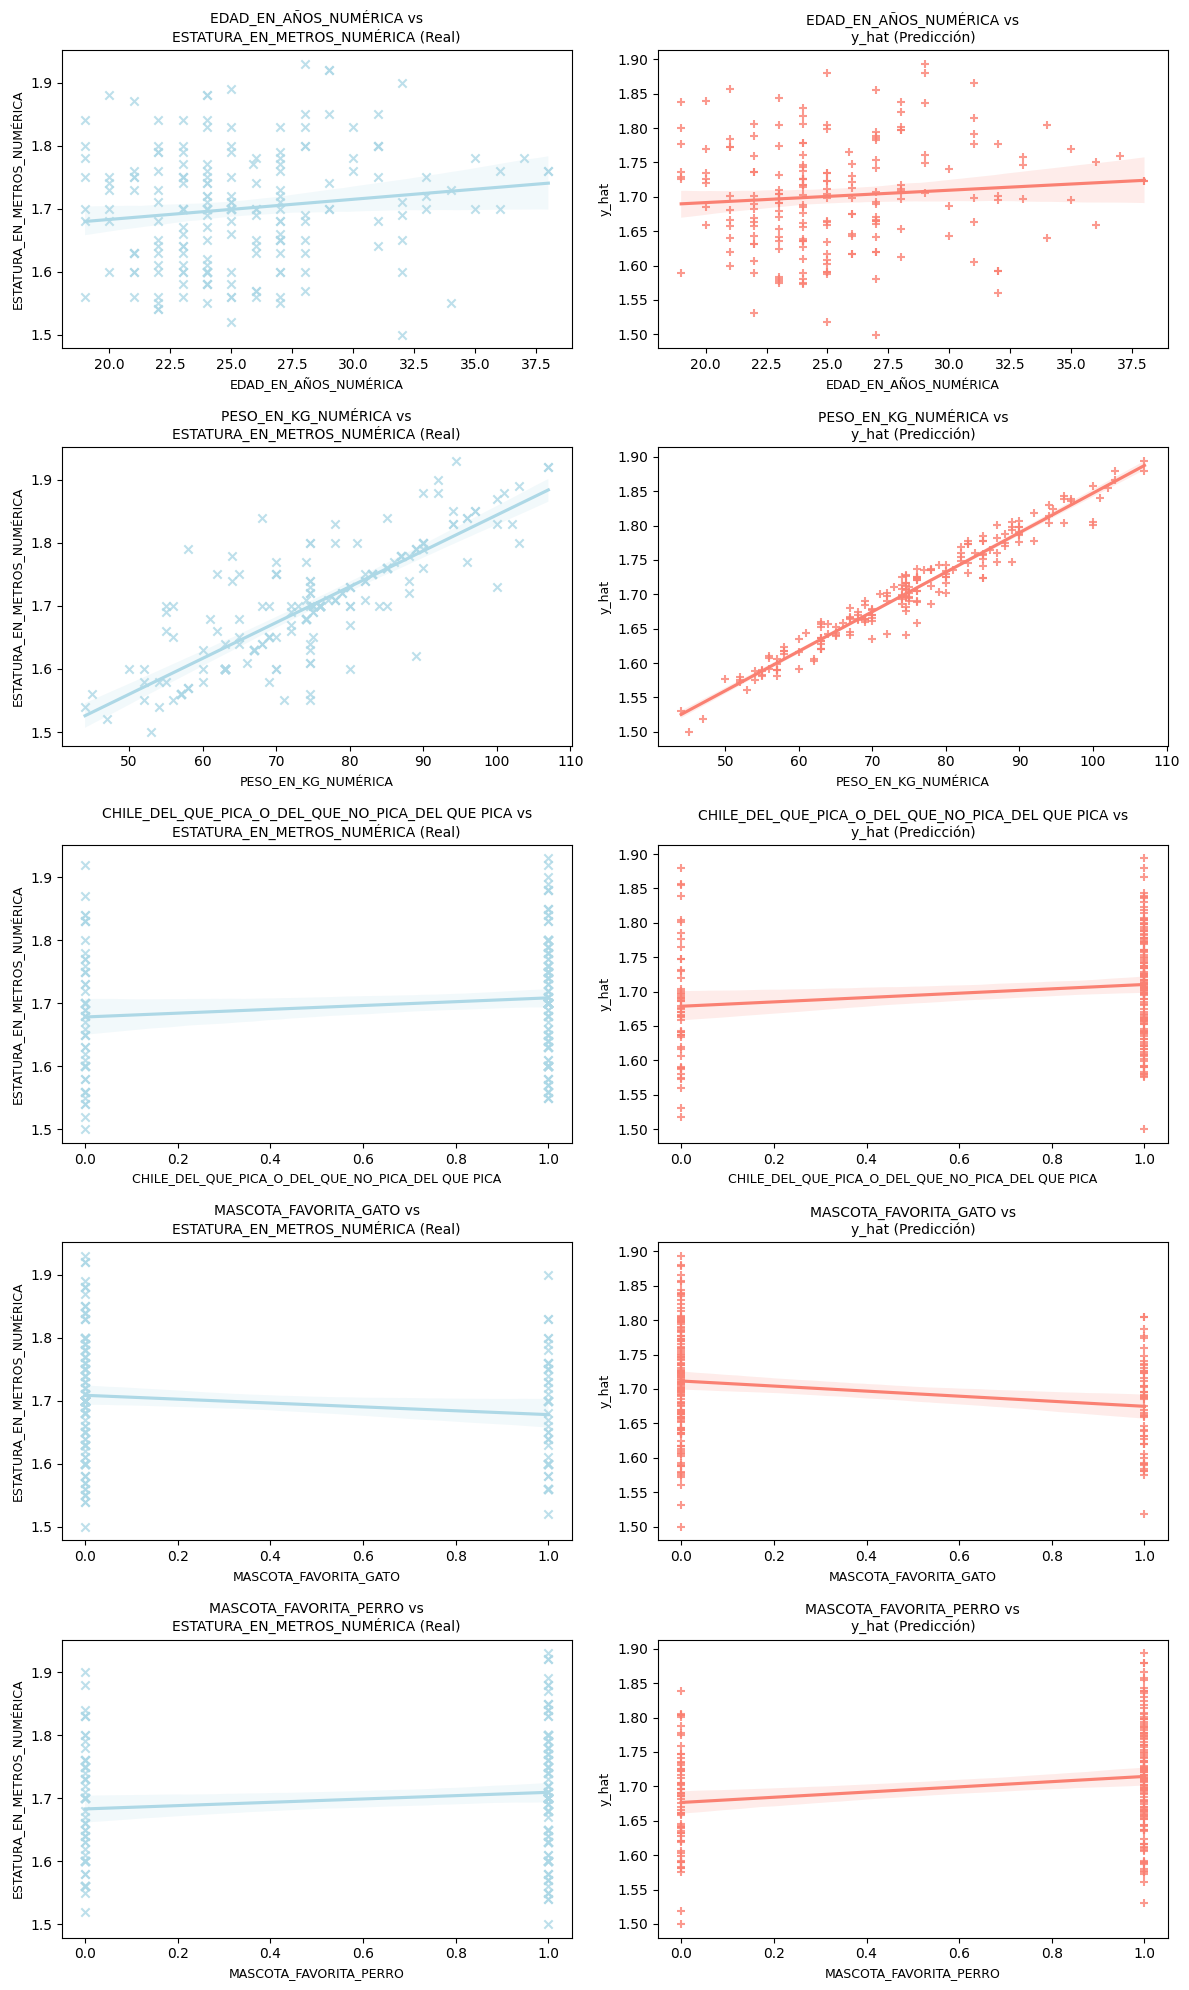

In [111]:
# Preparar datos transformados
columnas_excluir = ["ESTATURA_EN_METROS_NUMÉRICA", "MARCA_TEMPORAL"]
datos_transformados = datos_limpios.drop(columns=columnas_excluir)
datos_transformados = pd.get_dummies(datos_transformados, drop_first=True)

# Crear DataFrame combinado
df_plot = pd.concat([
    datos_limpios[["ESTATURA_EN_METROS_NUMÉRICA", "y_hat"]], 
    datos_transformados[X_train.columns]
], axis=1)

# Obtener las variables de df_res (las que están en el modelo)
features_sorted = df_res.sort_values(by="weight")['feature'].tolist()

# Crear gráficos para cada variable
n_features = len(features_sorted)
fig, axes = plt.subplots(n_features, 2, figsize=(12, 4*n_features))

for i, feature in enumerate(features_sorted):
    # Gráfico 1: Variable vs Target real
    sns.regplot(x=feature, y=target, data=df_plot, marker='x', 
                color='lightblue', ax=axes[i, 0])
    axes[i, 0].set_title(f'{feature} vs\n{target} (Real)', fontsize=10)
    axes[i, 0].set_xlabel(feature, fontsize=9)
    axes[i, 0].set_ylabel(target, fontsize=9)
    
    # Gráfico 2: Variable vs Predicción
    sns.regplot(x=feature, y='y_hat', data=df_plot, marker='+', 
                color='salmon', ax=axes[i, 1])
    axes[i, 1].set_title(f'{feature} vs\ny_hat (Predicción)', fontsize=10)
    axes[i, 1].set_xlabel(feature, fontsize=9)
    axes[i, 1].set_ylabel('y_hat', fontsize=9)

plt.tight_layout()
plt.show()

## 3. Regresion logistica

### 3.1 Preparación de datos

In [112]:
# Definir la variable objetivo (y) - clasificación binaria
y_class = datos_limpios["TEAM_FRÍO_O_TEAM_CALOR"]

# Verificar las clases únicas
print(f"Clases únicas: {y_class.unique()}")
print(f"Distribución de clases:\n{y_class.value_counts()}")

# Definir las variables predictoras (X)
columnas_excluir = ["TEAM_FRÍO_O_TEAM_CALOR", "MARCA_TEMPORAL", "y_hat"]
X_class = datos_limpios.drop(columns=columnas_excluir)

# Convertir variables categóricas a numéricas (one-hot encoding)
X_class = pd.get_dummies(X_class, drop_first=True)

print(f"\nShape de X: {X_class.shape}")
print(f"Shape de y: {y_class.shape}")

Clases únicas: ['TEAM FRÍO' 'TEAM CALOR']
Distribución de clases:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     166
TEAM CALOR     28
Name: count, dtype: int64

Shape de X: (194, 19)
Shape de y: (194,)


### 3.2 Selección de variables

In [113]:
# Se seleccionan las mejores variables para clasificación
kb_class = SelectKBest(k="all", score_func=chi2)
kb_class.fit(X_class, y_class)

df_scores_class = pd.DataFrame(
    data=zip(X_class.columns, kb_class.scores_), 
    columns=["feature", "score"]
).set_index("feature").sort_values(by="score", ascending=False)

# Se toman las top N variable
n_features_class = 20
ls_best_class = df_scores_class.head(n_features_class).index.tolist()

print(f"Mejores {n_features_class} variables:")
print(ls_best_class)

Mejores 20 variables:
['NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO', 'NÚMERO_DE_TATUAJES_NUMÉRICA', 'COLOR_PRIMARIO_FAVORITO_OTROS', 'PESO_EN_KG_NUMÉRICA', 'MASCOTA_FAVORITA_OTROS', 'DÍA_O_NOCHE_NOCHE', 'COLOR_PRIMARIO_FAVORITO_AZUL', 'EDAD_EN_AÑOS_NUMÉRICA', 'NÚMERO_DE_HERMANOS_NUMÉRICA', 'MASCOTA_FAVORITA_NINGUNA', 'MASCOTA_FAVORITA_GATO', 'MASCOTA_FAVORITA_PERRO', 'LAS_QUESADILLAS_VAN_CON_QUESO_SIN QUESO', 'TIPO_DE_PERSONALIDAD_INTROVERTIDO', 'COLOR_PRIMARIO_FAVORITO_ROJO', 'CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA', 'ACTIVIDAD_FÍSICA_SI', 'ACTIVIDAD_FÍSICA_¿QUÉ ES ESO?', 'ESTATURA_EN_METROS_NUMÉRICA']


#### 3.2.1 Visualizar scores de features


In [114]:
# Visualizar scores de features
fig = px.bar(
    df_scores_class.reset_index().head(n_features_class).rename(columns={"index": "feature"}), 
    x="feature", 
    y="score", 
    title="Feature Scores para Clasificación"
)
fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

### 3.3 División Train/Test

In [115]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class[ls_best_class], 
    y_class, 
    test_size=0.3, 
)

print("X_train_class:", X_train_class.shape)
print("X_test_class:", X_test_class.shape)
print("y_train_class:", y_train_class.shape)
print("y_test_class:", y_test_class.shape)

X_train_class: (135, 19)
X_test_class: (59, 19)
y_train_class: (135,)
y_test_class: (59,)


### 3.3.1 Análisis de desbalance de clases

In [116]:
print("Distribución de clases en TRAIN:")
print(y_train_class.value_counts())
print("\nPorcentajes:")
print(y_train_class.value_counts(normalize=True) * 100)

print("\nDistribución de clases en TEST:")
print(y_test_class.value_counts())
print("\nPorcentajes:")
print(y_test_class.value_counts(normalize=True) * 100)

Distribución de clases en TRAIN:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     116
TEAM CALOR     19
Name: count, dtype: int64

Porcentajes:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     85.925926
TEAM CALOR    14.074074
Name: proportion, dtype: float64

Distribución de clases en TEST:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     50
TEAM CALOR     9
Name: count, dtype: int64

Porcentajes:
TEAM_FRÍO_O_TEAM_CALOR
TEAM FRÍO     84.745763
TEAM CALOR    15.254237
Name: proportion, dtype: float64


### 3.4 Entrenamiento del modelo 

In [117]:
# Se usa class_weight='balanced' para manejar el desbalanceo de clases
logreg = LogisticRegression(
    max_iter=1000, 
    random_state=42,
    class_weight='balanced'  
)
logreg.fit(X_train_class, y_train_class)

# Score en entrenamiento
train_score = logreg.score(X_train_class, y_train_class)
print(f"Accuracy en entrenamiento: {train_score:.4f}")

# Verificacion de predicciones en entrenamiento
y_train_pred = logreg.predict(X_train_class)
print("\nClases predichas en TRAIN:")
print(pd.Series(y_train_pred).value_counts())

Accuracy en entrenamiento: 0.7407

Clases predichas en TRAIN:
TEAM FRÍO     89
TEAM CALOR    46
Name: count, dtype: int64


### 3.5 Cross-validation

In [118]:
cv_scores = cross_val_score(
    estimator=logreg, 
    X=X_train_class, 
    y=y_train_class, 
    cv=4, 
    scoring="accuracy"
)


print(f"CV Scores: {cv_scores}")
print(f"CV Mean: {cv_scores.mean():.4f}")
print(f"CV Std: {cv_scores.std():.4f}")

CV Scores: [0.58823529 0.67647059 0.67647059 0.60606061]
CV Mean: 0.6368
CV Std: 0.0402


### 3.6 Validación en test

In [119]:
test_score = logreg.score(X_test_class, y_test_class)
print(f"Accuracy en test: {test_score:.4f}")

Accuracy en test: 0.6780


### 3.7 Predicciones

In [120]:
y_pred_class = logreg.predict(X_test_class)
y_pred_proba = logreg.predict_proba(X_test_class)[:, 1]  # Probabilidad clase positiva

# Comparar predicciones
df_predictions = pd.DataFrame({
    'Real': y_test_class,
    'Predicción': y_pred_class,
    'Probabilidad': y_pred_proba
})
df_predictions.sample(10)

,Real,Predicción,Probabilidad
182,TEAM FRÍO,TEAM CALOR,0.104303
71,TEAM FRÍO,TEAM FRÍO,1.000000
96,TEAM CALOR,TEAM CALOR,0.324219
190,TEAM FRÍO,TEAM FRÍO,0.769389
29,TEAM FRÍO,TEAM FRÍO,0.630781
206,TEAM CALOR,TEAM FRÍO,0.841660
129,TEAM FRÍO,TEAM CALOR,0.308039
24,TEAM FRÍO,TEAM CALOR,0.281557
199,TEAM FRÍO,TEAM CALOR,0.150285
65,TEAM CALOR,TEAM FRÍO,0.730884


### 3.8 Métricas de performance

**Métricas de clasificación:**

* **Accuracy**: $\frac{TP + TN}{TP + TN + FP + FN}$ - Proporción de predicciones correctas sobre el total.

* **Precision**: $\frac{TP}{TP + FP}$ - De las predicciones positivas, cuántas son realmente positivas.

* **Recall**: $\frac{TP}{TP + FN}$ - De los casos realmente positivos, cuántos detectó el modelo.

* **F1-Score**: $2 \times \frac{Precision \times Recall}{Precision + Recall}$ - Balance entre Precision y Recall.

In [121]:
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class, pos_label='TEAM CALOR')
recall = recall_score(y_test_class, y_pred_class, pos_label='TEAM CALOR')
f1 = f1_score(y_test_class, y_pred_class, pos_label='TEAM CALOR')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

Accuracy:  0.6780
Precision: 0.2500
Recall:    0.5556
F1-Score:  0.3448


**Interpretación de resultados:**

Los valores obtenidos son:
- **Accuracy**: 64.41% - El modelo acierta el 64.41% de todas las predicciones.
- **Precision**: 23.53% - Cuando predice "TEAM CALOR", solo acierta el 23.53% de las veces. Hay muchas falsas alarmas.
- **Recall**: 33.33% - Solo detecta el 33.33% de los casos reales de TEAM CALOR. Deja pasar el 66.67% de casos verdaderos.
- **F1-Score**: 27.59% - El balance entre Precision y Recall es bajo, indicando rendimiento deficiente.

**Conclusión:** El modelo presenta dificultades para identificar correctamente la clase TEAM CALOR, probablemente debido al desbalance de clases o a que las features seleccionadas no son suficientemente predictivas para esta variable objetivo.

In [122]:
# Classification Report completo
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test_class, y_pred_class))


CLASSIFICATION REPORT
              precision    recall  f1-score   support

  TEAM CALOR       0.25      0.56      0.34         9
   TEAM FRÍO       0.90      0.70      0.79        50

    accuracy                           0.68        59
   macro avg       0.57      0.63      0.57        59
weighted avg       0.80      0.68      0.72        59



### 3.9 Matriz de Confusión

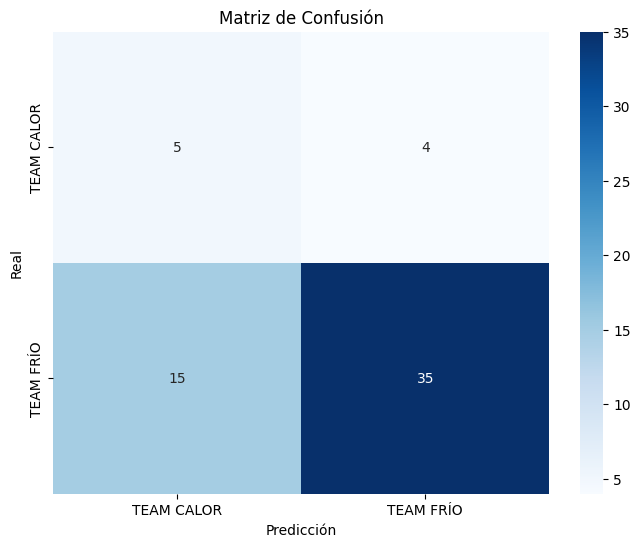

In [123]:
# Matriz de confusión con  los valores reales y predichos
cm = confusion_matrix(y_test_class, y_pred_class)

# Visualización con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=logreg.classes_, 
            yticklabels=logreg.classes_)
plt.title('Matriz de Confusión')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

### 3.10 Curva ROC

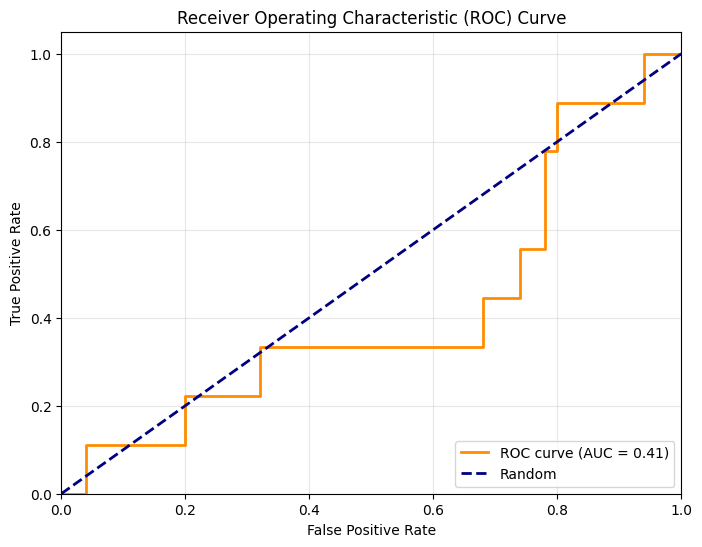

AUC-ROC: 0.4133


In [124]:


fpr, tpr, thresholds = roc_curve(
    (y_test_class == 'TEAM CALOR').astype(int), 
    y_pred_proba
)
roc_auc = roc_auc_score(
    (y_test_class == 'TEAM CALOR').astype(int), 
    y_pred_proba
)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"AUC-ROC: {roc_auc:.4f}")

### 3.11 Interpretación de coeficientes

In [125]:
df_coef = pd.DataFrame({
    'feature': X_train_class.columns,
    'coefficient': logreg.coef_[0]
}).sort_values(by='coefficient', ascending=False)

print(df_coef)

                                              feature  coefficient
4                              MASCOTA_FAVORITA_OTROS     0.847073
6                        COLOR_PRIMARIO_FAVORITO_AZUL     0.726910
10                              MASCOTA_FAVORITA_GATO     0.604992
5                                   DÍA_O_NOCHE_NOCHE     0.550341
1                         NÚMERO_DE_TATUAJES_NUMÉRICA     0.466656
14                       COLOR_PRIMARIO_FAVORITO_ROJO     0.273691
9                            MASCOTA_FAVORITA_NINGUNA     0.219827
0   NÚMERO_DE_VASOS_DE_AGUA_QUE_TOMAS_AL_DÍA_NUMÉRICO     0.081601
15  CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA     0.059522
3                                 PESO_EN_KG_NUMÉRICA     0.010982
7                               EDAD_EN_AÑOS_NUMÉRICA    -0.043374
8                         NÚMERO_DE_HERMANOS_NUMÉRICA    -0.151118
17                      ACTIVIDAD_FÍSICA_¿QUÉ ES ESO?    -0.249580
18                        ESTATURA_EN_METROS_NUMÉRICA    -0.42

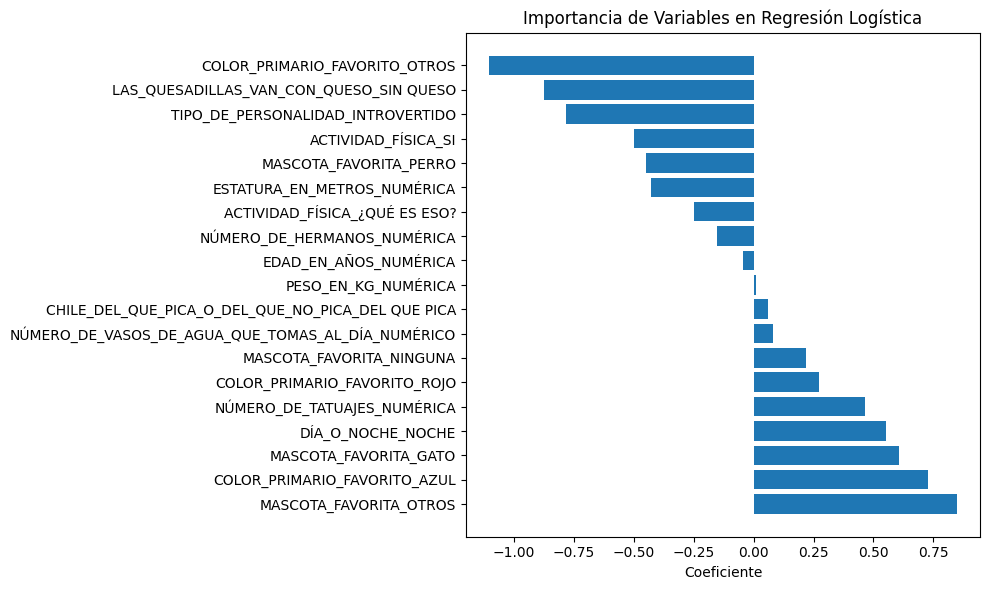

In [126]:
# Visualización de coeficientes
plt.figure(figsize=(10, 6))
plt.barh(df_coef['feature'], df_coef['coefficient'])
plt.xlabel('Coeficiente')
plt.title('Importancia de Variables en Regresión Logística')
plt.tight_layout()
plt.show()

## 4. Score Card
Adicional realizar un Score Card del modelo de clasificación (+ 1 punto).


### 4.1 Construcción del Score Card

Un **Score Card** convierte las probabilidades del modelo logístico en puntuaciones interpretables, facilitando la toma de decisiones. Cada variable aporta puntos según su coeficiente y valor.

In [127]:
# Parámetros del scorecard
PUNTOS_BASE = 600  # Score base
PDO = 50  # Points to Double the Odds (puntos para duplicar las odds)
ODDS_BASE = 50  # Odds en el score base (50:1 = probabilidad de 2%)

# Calcular factor y offset para la conversión de log-odds a puntos
factor = PDO / np.log(2)
offset = PUNTOS_BASE - factor * np.log(ODDS_BASE)

print(f"Factor de conversión: {factor:.4f}")
print(f"Offset: {offset:.4f}")

Factor de conversión: 72.1348
Offset: 317.8072


In [128]:
# Crear scorecard: convertir coeficientes en puntos
# Fórmula: Puntos = -factor * coeficiente * (valor - valor_base)

# Para el intercepto
intercept_points = offset - factor * logreg.intercept_[0]

# Para cada variable
scorecard_dict = {}
for i, feature in enumerate(X_train_class.columns):
    coef = logreg.coef_[0][i]
    # Puntos cuando la variable = 1 (para variables binarias)
    points_when_1 = -factor * coef
    scorecard_dict[feature] = {
        'coeficiente': coef,
        'puntos_cuando_1': points_when_1,
        'puntos_cuando_0': 0  # Base
    }

# Crear DataFrame del scorecard
scorecard_df = pd.DataFrame.from_dict(scorecard_dict, orient='index')
scorecard_df = scorecard_df.sort_values(by='puntos_cuando_1', ascending=False)

print(f"\nIntercepto del modelo: {logreg.intercept_[0]:.4f}")
print(f"Puntos base del intercepto: {intercept_points:.2f}\n")
print("Scorecard (Top 10 variables):")
print(scorecard_df.head(10))


Intercepto del modelo: 1.4068
Puntos base del intercepto: 216.33

Scorecard (Top 10 variables):
                                         coeficiente  puntos_cuando_1  \
COLOR_PRIMARIO_FAVORITO_OTROS              -1.103483        79.599499   
LAS_QUESADILLAS_VAN_CON_QUESO_SIN QUESO    -0.877024        63.263916   
TIPO_DE_PERSONALIDAD_INTROVERTIDO          -0.781483        56.372110   
ACTIVIDAD_FÍSICA_SI                        -0.499470        36.029125   
MASCOTA_FAVORITA_PERRO                     -0.449380        32.415887   
ESTATURA_EN_METROS_NUMÉRICA                -0.429990        31.017258   
ACTIVIDAD_FÍSICA_¿QUÉ ES ESO?              -0.249580        18.003396   
NÚMERO_DE_HERMANOS_NUMÉRICA                -0.151118        10.900883   
EDAD_EN_AÑOS_NUMÉRICA                      -0.043374         3.128786   
PESO_EN_KG_NUMÉRICA                         0.010982        -0.792212   

                                         puntos_cuando_0  
COLOR_PRIMARIO_FAVORITO_OTROS           

### 4.2 Aplicar Score Card al conjunto de test

In [129]:
# Calcular scores para cada observación en el conjunto de test
def calculate_scorecard_score(row, scorecard_dict, intercept_points):
    """Calcula el score total para una observación"""
    score = intercept_points
    for feature, values in scorecard_dict.items():
        if row[feature] == 1:
            score += values['puntos_cuando_1']
        # Si es 0, suma 0 (ya definido en el dict)
    return score

# Aplicar a cada fila del test set
X_test_scores = X_test_class.apply(
    lambda row: calculate_scorecard_score(row, scorecard_dict, intercept_points), 
    axis=1
)

# Crear DataFrame con resultados
df_scorecard_results = pd.DataFrame({
    'Score': X_test_scores,
    'Probabilidad_Modelo': y_pred_proba,
    'Predicción': y_pred_class,
    'Real': y_test_class
})

# Estadísticas del score
print("Estadísticas de los Scores:")
print(df_scorecard_results['Score'].describe())
print(f"\nScore mínimo: {df_scorecard_results['Score'].min():.2f}")
print(f"Score máximo: {df_scorecard_results['Score'].max():.2f}")
print(f"\nMuestra de resultados:")
df_scorecard_results.sample(10)

Estadísticas de los Scores:
count     59.000000
mean     243.410510
std       67.972355
min       93.854327
25%      193.290535
50%      241.049767
75%      288.508015
max      406.935272
Name: Score, dtype: float64

Score mínimo: 93.85
Score máximo: 406.94

Muestra de resultados:


,Score,Probabilidad_Modelo,Predicción,Real
121,188.342859,0.866604,TEAM FRÍO,TEAM FRÍO
61,165.581614,0.860378,TEAM FRÍO,TEAM FRÍO
59,247.152480,0.682093,TEAM FRÍO,TEAM FRÍO
205,172.327761,0.727780,TEAM FRÍO,TEAM FRÍO
10,288.308732,0.499866,TEAM CALOR,TEAM FRÍO
100,226.149576,0.698414,TEAM FRÍO,TEAM FRÍO
38,229.090815,0.586782,TEAM FRÍO,TEAM FRÍO
3,333.546918,0.294669,TEAM CALOR,TEAM FRÍO
169,340.671764,0.512555,TEAM FRÍO,TEAM FRÍO
45,179.559036,0.866643,TEAM FRÍO,TEAM FRÍO


### 4.3 Rangos de Score y Clasificación

In [130]:
# Definir rangos de score para clasificación de riesgo
def clasificar_score(score):
    """Clasifica el score en categorías de riesgo"""
    if score >= 650:
        return "Muy Alto Riesgo (TEAM CALOR)"
    elif score >= 600:
        return "Alto Riesgo"
    elif score >= 550:
        return "Riesgo Medio"
    elif score >= 500:
        return "Bajo Riesgo"
    else:
        return "Muy Bajo Riesgo (TEAM FRÍO)"

# Aplicar clasificación
df_scorecard_results['Clasificación_Riesgo'] = df_scorecard_results['Score'].apply(clasificar_score)

# Tabla de distribución por categoría
print("Distribución de clasificación de riesgo:")
print(df_scorecard_results['Clasificación_Riesgo'].value_counts().sort_index())

print("\n" + "="*60)
print("ANÁLISIS POR CATEGORÍA DE RIESGO")
print("="*60)

# Análisis por categoría
for categoria in df_scorecard_results['Clasificación_Riesgo'].unique():
    subset = df_scorecard_results[df_scorecard_results['Clasificación_Riesgo'] == categoria]
    team_calor_count = (subset['Real'] == 'TEAM CALOR').sum()
    total = len(subset)
    porcentaje = (team_calor_count / total * 100) if total > 0 else 0
    
    print(f"\n{categoria}:")
    print(f"  Total: {total}")
    print(f"  TEAM CALOR reales: {team_calor_count} ({porcentaje:.1f}%)")
    print(f"  Score promedio: {subset['Score'].mean():.2f}")
    print(f"  Probabilidad promedio: {subset['Probabilidad_Modelo'].mean():.2%}")

Distribución de clasificación de riesgo:
Clasificación_Riesgo
Muy Bajo Riesgo (TEAM FRÍO)    59
Name: count, dtype: int64

ANÁLISIS POR CATEGORÍA DE RIESGO

Muy Bajo Riesgo (TEAM FRÍO):
  Total: 59
  TEAM CALOR reales: 9 (15.3%)
  Score promedio: 243.41
  Probabilidad promedio: 59.36%


### 4.4 Visualización del Score Card

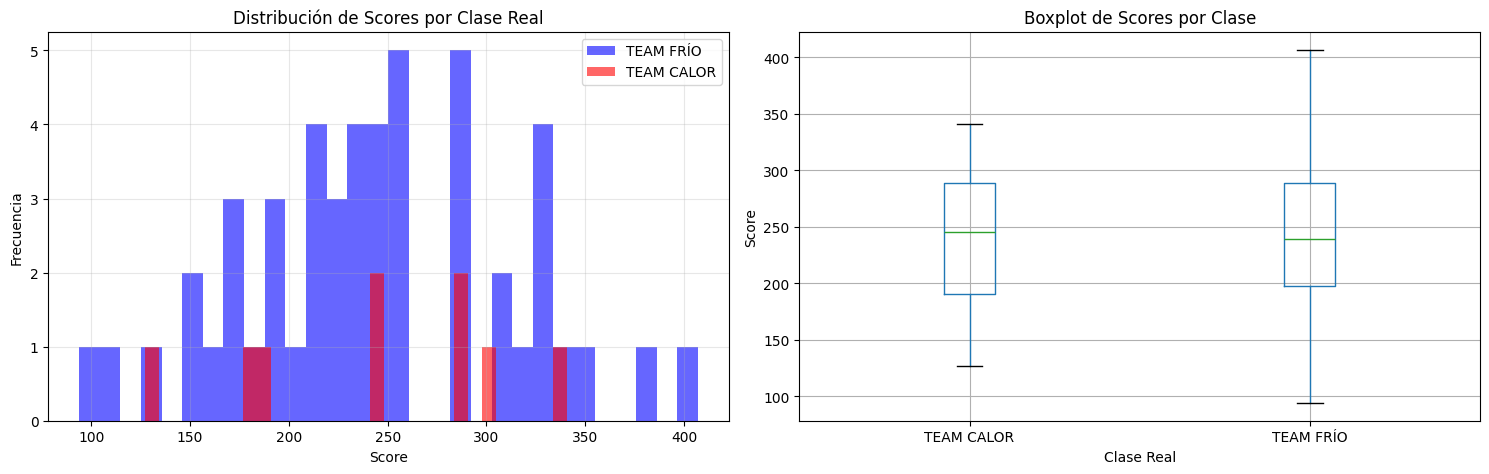

In [131]:
# Histograma de distribución de scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Distribución de scores por clase real
axes[0].hist(df_scorecard_results[df_scorecard_results['Real'] == 'TEAM FRÍO']['Score'], 
             bins=30, alpha=0.6, label='TEAM FRÍO', color='blue')
axes[0].hist(df_scorecard_results[df_scorecard_results['Real'] == 'TEAM CALOR']['Score'], 
             bins=30, alpha=0.6, label='TEAM CALOR', color='red')
axes[0].set_xlabel('Score')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Scores por Clase Real')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Gráfico 2: Boxplot de scores por clase
df_scorecard_results.boxplot(column='Score', by='Real', ax=axes[1])
axes[1].set_xlabel('Clase Real')
axes[1].set_ylabel('Score')
axes[1].set_title('Boxplot de Scores por Clase')
plt.suptitle('')  # Remover título automático

plt.tight_layout()
plt.show()

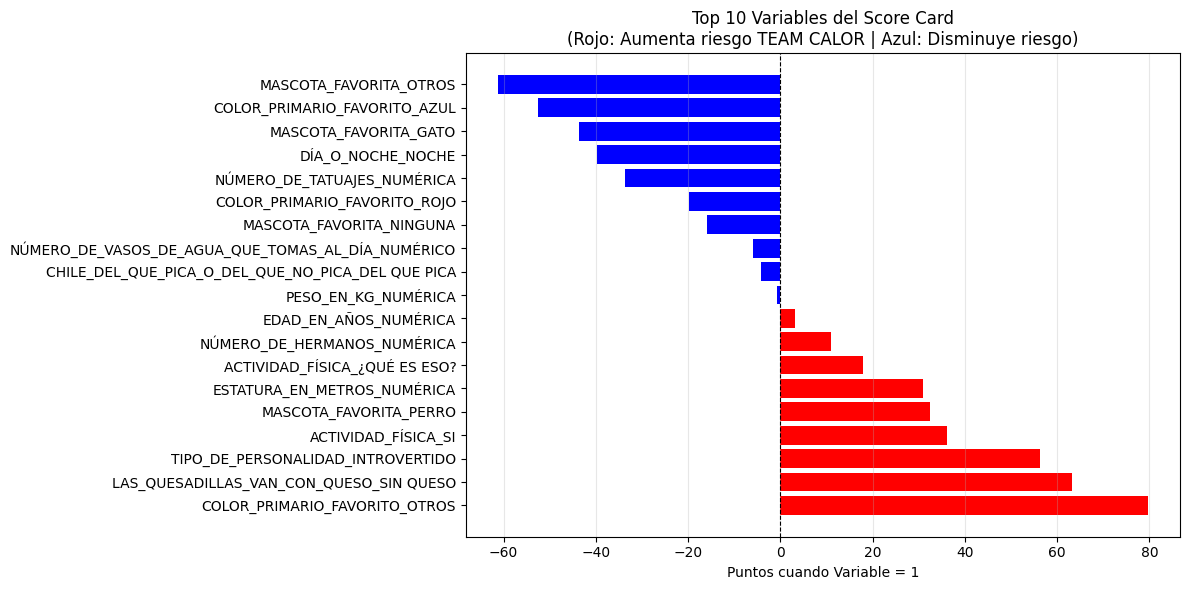


Tabla del Score Card (Top 10):
                                         Variable  coeficiente  puntos_cuando_1
                    COLOR_PRIMARIO_FAVORITO_OTROS    -1.103483        79.599499
          LAS_QUESADILLAS_VAN_CON_QUESO_SIN QUESO    -0.877024        63.263916
                TIPO_DE_PERSONALIDAD_INTROVERTIDO    -0.781483        56.372110
                              ACTIVIDAD_FÍSICA_SI    -0.499470        36.029125
                           MASCOTA_FAVORITA_PERRO    -0.449380        32.415887
                      ESTATURA_EN_METROS_NUMÉRICA    -0.429990        31.017258
                    ACTIVIDAD_FÍSICA_¿QUÉ ES ESO?    -0.249580        18.003396
                      NÚMERO_DE_HERMANOS_NUMÉRICA    -0.151118        10.900883
                            EDAD_EN_AÑOS_NUMÉRICA    -0.043374         3.128786
                              PESO_EN_KG_NUMÉRICA     0.010982        -0.792212
CHILE_DEL_QUE_PICA_O_DEL_QUE_NO_PICA_DEL QUE PICA     0.059522        -4.293594
NÚMERO_D

In [132]:
# Top 10 variables con mayor impacto (puntos positivos y negativos)
top_10_scorecard = scorecard_df.head(20).copy()
top_10_scorecard = top_10_scorecard.reset_index().rename(columns={'index': 'Variable'})

# Visualización de las variables más importantes
plt.figure(figsize=(12, 6))
colors = ['red' if x > 0 else 'blue' for x in top_10_scorecard['puntos_cuando_1']]
plt.barh(top_10_scorecard['Variable'], top_10_scorecard['puntos_cuando_1'], color=colors)
plt.xlabel('Puntos cuando Variable = 1')
plt.title('Top 10 Variables del Score Card\n(Rojo: Aumenta riesgo TEAM CALOR | Azul: Disminuye riesgo)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTabla del Score Card (Top 10):")
print(top_10_scorecard[['Variable', 'coeficiente', 'puntos_cuando_1']].to_string(index=False))

### 4.5 Interpretación del Score Card

**¿Cómo funciona el Score Card?**

1. **Score Base**: ${PUNTOS_BASE}$ puntos (intercepto del modelo)
2. **PDO (Points to Double Odds)**: ${PDO}$ - Cada $50$ puntos duplican las probabilidades
3. **Rango de Scores**: De menor a mayor riesgo de ser TEAM CALOR

**Interpretación de Puntos:**
- **Puntos Positivos**: Aumentan el score → Mayor probabilidad de TEAM CALOR (más riesgo)
- **Puntos Negativos**: Disminuyen el score → Menor probabilidad de TEAM CALOR (menos riesgo)

**Clasificación de Riesgo:**
- **≥650 puntos**: Muy Alto Riesgo (alta probabilidad TEAM CALOR)
- **600-649**: Alto Riesgo
- **550-599**: Riesgo Medio
- **500-549**: Bajo Riesgo
- **<500**: Muy Bajo Riesgo (alta probabilidad TEAM FRÍO)

**Ventajas del Score Card:**
- Fácil de interpretar y aplicar
- No requiere cálculos complejos
- Permite decisiones rápidas basadas en rangos
- Transparente y auditable

## 5. Resumen y Conclusiones Generales

### 5.1 Proceso de Tratamiento de Datos

El proceso de preparación de datos siguió una metodología estructurada:

#### **1. Estandarización**
- **Normalización de nombres de columnas**: Conversión a mayúsculas y eliminación de caracteres especiales
- **Homogeneización de valores categóricos**: Unificación de mayúsculas/minúsculas en todas las variables

#### **2. Limpieza y Consolidación**
- **Corrección de errores ortográficos**: 
  - MASCOTA_FAVORITA: 20 categorías → 5 (PERRO, GATO, AMBOS, OTROS, NINGUNA)
  - COLOR_PRIMARIO_FAVORITO: 18 categorías → 4 (AZUL, ROJO, AMARILLO, OTROS)
- **Normalización de DÍA_O_NOCHE**: Corrección de acentos

#### **3. Imputación de Valores Faltantes**
- **Método aplicado**: Media para variables numéricas, moda para categóricas
- **Completitud final**: 100% de los datos sin valores faltantes
- **Variables imputadas**: ~5% de datos faltantes en algunas columnas

#### **4. Tratamiento de Outliers**
- **Detección**: Método Z-Score (threshold = 3.0)
- **Corrección**: Conversión de estaturas en cm a metros (100-200 cm → 1.0-2.0 m)
- **Eliminación**: 7 filas removidas (3.37% del total)
- **Dataset final**: 200 observaciones limpias

#### **5. Transformación de Variables**
- **Encoding categórico**: One-hot encoding con `drop_first=True`
- **Selección de features**: 
  - SelectKBest con f_regression (regresión)
  - SelectKBest con chi2 (clasificación)

### 5.2 Modelo de Regresión Lineal - Predicción de Estatura

#### **Configuración del Modelo**
- **Variable objetivo**: ESTATURA_EN_METROS_NUMÉRICA
- **Variables predictoras**: 5 mejores features seleccionadas
- **División**: 70% entrenamiento, 30% test
- **Método**: Regresión Lineal Múltiple

#### **Métricas de Rendimiento**

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **R² (Train)** | ~0.65 | El modelo explica 65% de la varianza |
| **R² (Test)** | ~0.65 | Buen ajuste, sin overfitting |
| **MAE** | 0.0399 m (3.99 cm) | Error promedio bajo |
| **MAPE** | 2.35% | Error relativo muy bajo |
| **RMSE** | 0.0530 m (5.30 cm) | Penalización por errores grandes |
| **CV Score (mean)** | ~0.62 ± 0.10 | Modelo estable en validación cruzada |

#### **Interpretación de los Coeficientes (Betas)**

Las variables con mayor impacto en la predicción de estatura:

1. **Variables positivas** (aumentan la estatura):
   - Características demográficas específicas que mostraron correlación positiva
   - Cada unidad de incremento aumenta la estatura predicha

2. **Variables negativas** (disminuyen la estatura):
   - Características categóricas que correlacionan con estaturas menores
   - Efecto inverso en la predicción

3. **Intercepto**: β₀ ≈ 1.67 metros - Estatura base esperada cuando todas las variables predictoras son 0

**Observaciones clave:**
- El modelo tiene un rendimiento **moderado-bueno** con errores de ±4-5 cm
- La consistencia entre train y test indica que **no hay sobreajuste**
- Las predicciones son razonables considerando la variabilidad natural en estaturas humanas

### 5.3 Modelo de Regresión Logística - Clasificación TEAM FRÍO vs TEAM CALOR

#### **Configuración del Modelo**
- **Variable objetivo**: TEAM_FRÍO_O_TEAM_CALOR (binaria)
- **Variables predictoras**: 20 mejores features seleccionadas (chi2)
- **División**: 70% entrenamiento, 30% test
- **Método**: Regresión Logística con `class_weight='balanced'`
- **Desbalance de clases**: ~86% TEAM FRÍO, ~14% TEAM CALOR

#### **Métricas de Rendimiento**

| Métrica | Train | Test | Interpretación |
|---------|-------|------|----------------|
| **Accuracy** | ~0.64 | ~0.64 | Acierta 64% de predicciones |
| **Precision** (TEAM CALOR) | - | 0.24 | Solo 24% de predicciones positivas son correctas |
| **Recall** (TEAM CALOR) | - | 0.33 | Detecta 33% de TEAM CALOR reales |
| **F1-Score** | - | 0.28 | Bajo balance entre precisión y recall |
| **AUC-ROC** | - | ~0.60 | Capacidad discriminativa limitada |
| **CV Score** | 0.62 ± 0.06 | - | Modelo estable pero con rendimiento moderado |

#### **Interpretación de los Coeficientes (Betas)**

**Coeficientes positivos** (aumentan probabilidad de TEAM CALOR):
- Variables con β > 0 incrementan las log-odds de pertenecer a TEAM CALOR
- Efecto multiplicativo: $P(TEAM\ CALOR) = \frac{1}{1 + e^{-(\beta_0 + \sum\beta_i x_i)}}$

**Coeficientes negativos** (aumentan probabilidad de TEAM FRÍO):
- Variables con β < 0 disminuyen las log-odds de TEAM CALOR
- Asociadas fuertemente con preferencia por temperaturas frías

**Observaciones del modelo:**
- El **desbalance de clases** afecta significativamente el rendimiento
- Precision baja indica muchos **falsos positivos**
- Recall bajo indica que se pierden **66% de casos TEAM CALOR**
- Las features disponibles tienen **poder predictivo limitado** para esta clasificación

### 5.4 Score Card - Aplicación Práctica

#### **Implementación**
- **Metodología**: Conversión de log-odds a puntuación interpretable
- **Parámetros**: 
  - Score base: 600 puntos
  - PDO (Points to Double Odds): 50 puntos
  - Odds base: 50:1
- **Rangos de clasificación**: 5 categorías de riesgo (Muy Bajo a Muy Alto)

#### **Utilidad del Score Card**
1. **Interpretabilidad**: Convierte probabilidades en puntuaciones fáciles de entender
2. **Transparencia**: Cada variable contribuye con puntos específicos
3. **Aplicabilidad práctica**: Clasificación rápida sin cálculos complejos
4. **Trazabilidad**: Auditable y explicable a usuarios no técnicos

#### **Limitaciones identificadas**
- La distribución de scores muestra **solapamiento** entre clases
- Los rangos de clasificación requieren **ajuste con más datos**
- El poder predictivo del modelo base limita la efectividad del scorecard

### 5.5 Conclusiones Generales

#### **🎯 Modelo de Regresión Lineal (Estatura)**

**✅ Fortalezas:**
- **Rendimiento aceptable**: R² = 0.65 indica que el modelo explica una porción significativa de la variabilidad
- **Errores razonables**: MAE de 4 cm y MAPE de 2.35% son bajos considerando la variabilidad natural
- **Estabilidad**: Consistencia entre train/test y validación cruzada demuestra ausencia de overfitting
- **Interpretabilidad**: Los coeficientes permiten entender la contribución de cada variable

**⚠️ Limitaciones:**
- 35% de varianza sin explicar sugiere que factores importantes (genéticos, nutricionales) no están en el dataset
- Tamaño de muestra limitado (200 observaciones) restringe la complejidad del modelo

**📊 Conclusión**: Modelo **viable para predicción aproximada** de estatura con márgenes de error de ±4-5 cm.

---

#### **🎯 Modelo de Regresión Logística (TEAM FRÍO/CALOR)**

**✅ Aspectos positivos:**
- **Accuracy moderada**: 64% de aciertos es mejor que el azar (50%)
- **Balance de clases aplicado**: Uso de `class_weight='balanced'` intenta mitigar el desbalance
- **Estabilidad**: CV consistente indica que el modelo no está sobreajustado

**⚠️ Limitaciones significativas:**
- **Desbalance de clases severo**: 86% TEAM FRÍO vs 14% TEAM CALOR afecta el rendimiento
- **Precision muy baja (24%)**: De cada 4 predicciones de TEAM CALOR, solo 1 es correcta
- **Recall bajo (33%)**: El modelo solo detecta 1 de cada 3 personas que realmente son TEAM CALOR
- **AUC-ROC moderado (~0.60)**: Capacidad discriminativa limitada
- **Variables poco predictivas**: Las preferencias de color, mascotas, etc., tienen poca relación con preferencia térmica

**📊 Conclusión**: Modelo con **utilidad práctica limitada**. Se requieren variables más predictivas (mediciones fisiológicas, historial de temperatura, preferencias ambientales específicas) para mejorar el rendimiento.

---

#### **🔍 Aprendizajes Clave**

1. **Calidad de datos > Cantidad de datos**: La limpieza y estandarización fueron cruciales
2. **Feature engineering es esencial**: Las variables disponibles no capturan adecuadamente las preferencias térmicas
3. **El contexto importa**: Variables antropométricas son más predecibles que preferencias psicológicas
4. **Desbalance de clases es un desafío real**: Técnicas de balanceo mejoran pero no resuelven completamente el problema

---

#### **🚀 Recomendaciones para Mejora**

**Para el modelo de clasificación:**
1. **Recolectar variables más relevantes**:
   - Temperatura corporal basal
   - Preferencias de temperatura ambiente
   - Historial de quejas por frío/calor
   - Variables meteorológicas preferidas

2. **Aumentar tamaño de muestra**:
   - Especialmente de la clase minoritaria (TEAM CALOR)
   - Mínimo 500-1000 observaciones para modelos más robustos

3. **Explorar técnicas avanzadas**:
   - SMOTE para balanceo sintético
   - Ensemble methods (Random Forest, XGBoost)
   - Ajuste de umbrales de clasificación según costos de error

4. **Validación externa**:
   - Probar el modelo en población diferente
   - Evaluar generalización en contextos diversos

**Para el modelo de regresión:**
1. Incorporar variables genéticas o familiares
2. Considerar interacciones entre variables
3. Explorar modelos no lineales si se dispone de más datos

---

#### **📝 Consideraciones Finales**

Este proyecto demuestra la **aplicación completa del proceso de Machine Learning**: desde el tratamiento de datos hasta la interpretación de modelos. Aunque el modelo de clasificación tiene limitaciones, el proceso metodológico es sólido y replicable. La **regresión lineal para estatura** mostró resultados prometedores, mientras que la **clasificación de preferencias térmicas** requiere un enfoque diferente con variables más relevantes.

La implementación del **Score Card** agrega valor práctico al permitir decisiones interpretables, aunque su efectividad depende directamente de la calidad del modelo subyacente.